Imports básicos para Pytorch 

In [1]:
import torch                                            # PyTorch deep learning framework
from torchvision import datasets, models, transforms    # extension to PyTorch for dataset management
import torch.nn as nn                                   # neural networks module of PyTorch, to let us define neural network layers
from torch.nn import functional as F                    # special functions
import torch.optim as optim                             # optimizers

In [2]:
import matplotlib.pyplot as plt  # graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline
from glob import glob
from math import floor
from PIL import Image 
import os 
from tqdm import tnrange, tqdm_notebook

Definición de nuestra red neuronal

In [3]:
def printDirectories():
    print("Data contents:", os.listdir("data"))
    print("Train contents:", os.listdir("data/train"))
    print("Validation contents:", os.listdir("data/validation"))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [5]:
def showSampleData():
    _, ax = plt.subplots(1, 4, figsize=(15,60))  
    ax[0].imshow(Image.open("data/train/chihuahua/2.jpg")) 
    ax[1].imshow(Image.open("data/train/chihuahua/17.jpg"))  
    ax[2].imshow(Image.open("data/train/muffin/79.jpg"))   
    ax[3].imshow(Image.open("data/train/muffin/136.jpg"))   

In [6]:
def transformsDefinition():
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
    train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
    validation_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
    return train_transforms, validation_transforms

In [7]:
def datasetsDefinition(train_transforms, validation_transforms):
    image_datasets = {
        'train': datasets.ImageFolder('data/train', train_transforms),
        'validation': datasets.ImageFolder('data/validation', validation_transforms)
    }
    return image_datasets

In [8]:
def dataloadersDefinition(image_datasets):
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(
                image_datasets['train'],
                batch_size=8,
                shuffle=True,
                num_workers=4),
        'validation':
            torch.utils.data.DataLoader(
                image_datasets['validation'],
                batch_size=8,
                shuffle=False,
                num_workers=4)}
    return dataloaders

In [9]:
def saveCheckpoint(model, filepath):
    checkpoint = { 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, filepath)

In [30]:
def loadCheckpoint(model, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [11]:
class AleNet(nn.Module):
    
    def __init__(self, input_dim=(3, 224, 224)):
        """
        input_dim: RGB x height x width
        """
        super().__init__()
        # el numero de pixels RGB es el tamaño
        num_in_features = input_dim[0] * input_dim[1] * input_dim[2]
        self.layer_0 = nn.Linear(num_in_features, 128)
        self.layer_1 = nn.Linear(128, 64)
        self.layer_2= nn.Linear(64, 32)
        self.layer_3= nn.Linear(32, 2)

    def forward(self, x):
        batch_size = x.shape[0]
        # Se pasa de RGB a vector
        x = x.view(batch_size, -1)
        
        x = F.relu(self.layer_0(x))
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        
        x = F.softmax(x, dim=1)
        
        return x

In [12]:
class AleNet2(nn.Module):
    
    def __init__(self, input_dim=(3, 224, 224)):
        """
        input_dim: RGB x height x width
        """
        super().__init__()
        # el numero de pixels RGB es el tamaño
        num_in_features = input_dim[0] * input_dim[1] * input_dim[2]
        self.layer_0 = nn.Linear(num_in_features, 500)
        self.layer_1 = nn.Linear(500, 100)
        self.layer_2= nn.Linear(100, 2)


    def forward(self, x):
        batch_size = x.shape[0]
        # Se pasa de RGB a vector
        x = x.view(batch_size, -1)
        
        x = F.relu(self.layer_0(x))
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))

        x = F.softmax(x, dim=1)
        
        return x

In [30]:
model = AleNet().to(device)                      # load our simple neural network
model

AleNet(
  (layer_0): Linear(in_features=150528, out_features=128, bias=True)
  (layer_1): Linear(in_features=128, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=2, bias=True)
)

In [13]:
model2 = AleNet2().to(device)                      # load our simple neural network
model2

AleNet2(
  (layer_0): Linear(in_features=150528, out_features=500, bias=True)
  (layer_1): Linear(in_features=500, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=2, bias=True)
)

In [14]:
printDirectories()

Data contents: ['train', 'validation']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']


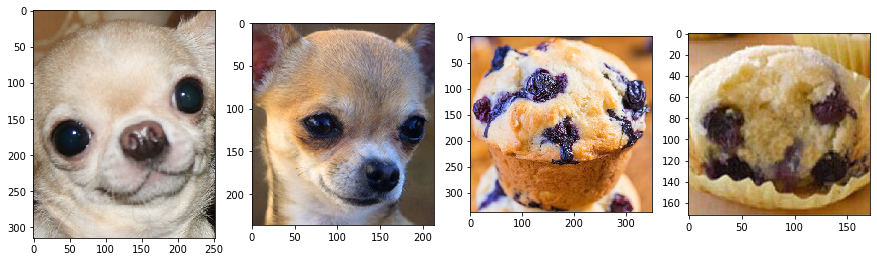

In [15]:
showSampleData()

Transformaciones para los entrenamientos

In [16]:
train_transforms, validation_transforms = transformsDefinition()
print("Train transforms:", train_transforms)

Train transforms: Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [17]:
image_datasets = datasetsDefinition(train_transforms, validation_transforms)
print(" --> Train Dataset \n", image_datasets["train"])
print(" --> Validation Dataset \n", image_datasets["validation"])

 --> Train Dataset 
 Dataset ImageFolder
    Number of datapoints: 120
    Root Location: data/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None
 --> Validation Dataset 
 Dataset ImageFolder
    Number of datapoints: 30
    Root Location: data/validation
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None


In [18]:
dataloaders = dataloadersDefinition(image_datasets)
print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x0000026F0078EB00>
Validation loader: <torch.utils.data.dataloader.DataLoader object at 0x0000026F0078E240>


In [34]:
next(iter(dataloaders["train"]))

[tensor([[[[ 0.0196,  0.0745,  0.0980,  ...,  0.5843,  0.5608,  0.4824],
           [ 0.0275,  0.0431,  0.0510,  ...,  0.5843,  0.5686,  0.5529],
           [-0.0039,  0.0039,  0.0118,  ...,  0.6157,  0.6000,  0.6235],
           ...,
           [ 0.3333,  0.1765,  0.1843,  ...,  0.7490,  0.7804,  0.7804],
           [ 0.3255,  0.2941,  0.3098,  ...,  0.7725,  0.8039,  0.8196],
           [ 0.2549,  0.2941,  0.2549,  ...,  0.8039,  0.8118,  0.8118]],
 
          [[-0.0275,  0.0275,  0.0510,  ...,  0.7020,  0.6784,  0.6000],
           [-0.0196, -0.0039, -0.0039,  ...,  0.7020,  0.6863,  0.6706],
           [-0.0510, -0.0431, -0.0431,  ...,  0.7333,  0.7176,  0.7412],
           ...,
           [ 0.4275,  0.2706,  0.2706,  ...,  0.8118,  0.8431,  0.8431],
           [ 0.4431,  0.4118,  0.4118,  ...,  0.8353,  0.8588,  0.8745],
           [ 0.3804,  0.4196,  0.3804,  ...,  0.8588,  0.8667,  0.8667]],
 
          [[-0.2000, -0.1451, -0.1294,  ...,  0.8588,  0.8431,  0.7804],
           [-

In [19]:
def train_model(model, dataloaders, loss_function, optimizer, num_epochs):
   
    for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('----------------')

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()  
                    loss.backward()        
                    optimizer.step()       

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} error: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        print()

In [31]:
loss_function = nn.CrossEntropyLoss()    
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [34]:
train_model(model, dataloaders, loss_function, optimizer, num_epochs=10)

Epoch 1/10
----------------


RuntimeError: CUDA out of memory. Tried to allocate 73.50 MiB (GPU 0; 2.00 GiB total capacity; 1.29 GiB already allocated; 51.86 MiB free; 65.46 MiB cached)

In [33]:
torch.cuda.empty_cache()

In [20]:
loss_function = nn.CrossEntropyLoss()    
optimizer = optim.SGD(model2.parameters(), lr=0.1)

In [21]:
train_model(model2, dataloaders, loss_function, optimizer, num_epochs=4)

Epoch 1/4
----------------


train error: 0.6491, Accuracy: 0.5750


validation error: 0.5660, Accuracy: 0.7333

Epoch 2/4
----------------


train error: 0.5484, Accuracy: 0.7750


validation error: 0.5794, Accuracy: 0.7000

Epoch 3/4
----------------


train error: 0.4532, Accuracy: 0.9167


validation error: 0.4470, Accuracy: 0.9000

Epoch 4/4
----------------


train error: 0.3931, Accuracy: 0.9250


validation error: 0.4362, Accuracy: 0.8667




In [24]:
saveCheckpoint(model2, "checkpoints/cp_model2.pth")

In [31]:
model_ = loadCheckpoint(model2, "checkpoints/cp_model2.pth")

In [22]:
def validation(model):
    validation_img_paths = glob("data/validation/**/*.jpg", recursive=True)
    images = [Image.open(img_path) for img_path in validation_img_paths]

    validation_batch = torch.stack( [validation_transforms(img).to(device) for img in images])
    pred_logits_tensor = model(validation_batch)
    pred_probs = pred_logits_tensor.cpu().data.numpy()

    fig, axs = plt.subplots(6, 5, figsize=(20, 20))
    for i, img in enumerate(images):
        ax = axs[floor(i/5)][i % 5]
        ax.axis('off')
        ax.set_title("{:.0f}% Chihu, {:.0f}% Muffin".format(100*pred_probs[i,0], 100*pred_probs[i,1]), fontsize=18)
        ax.imshow(img)

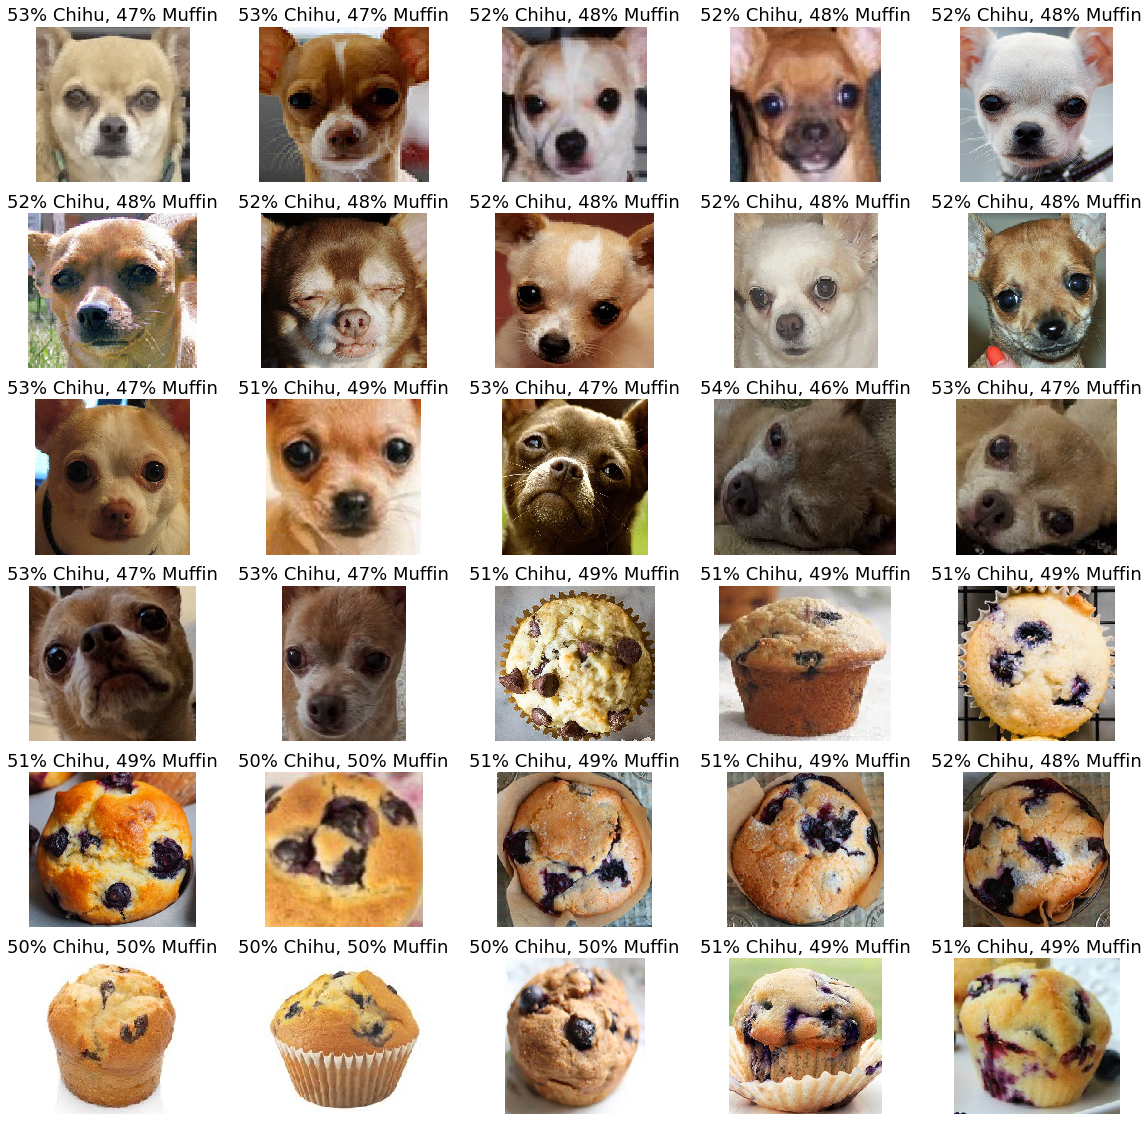

In [33]:
validation(model)

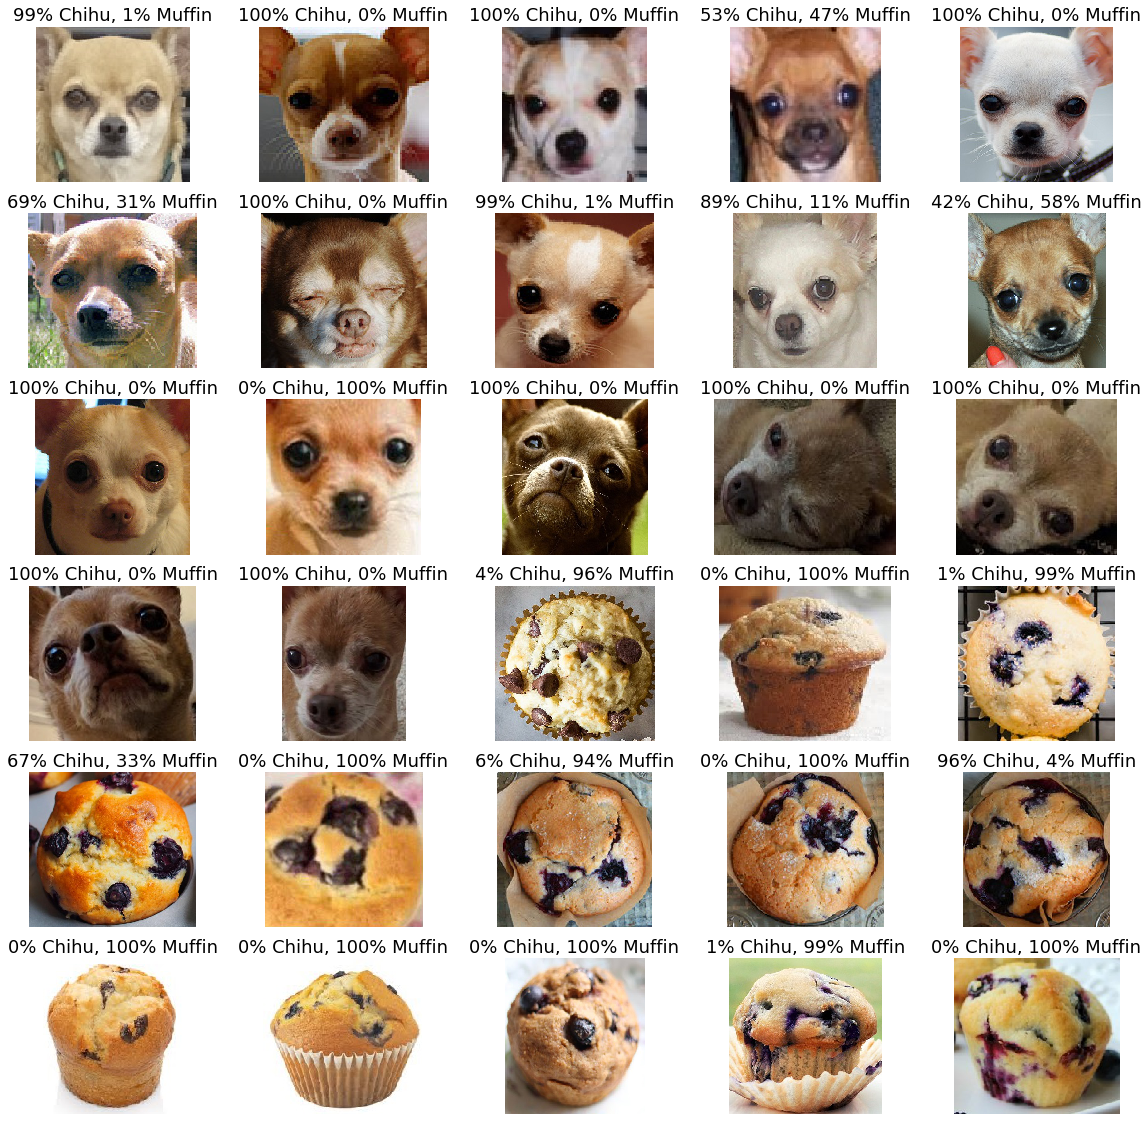

In [32]:
validation(model_)

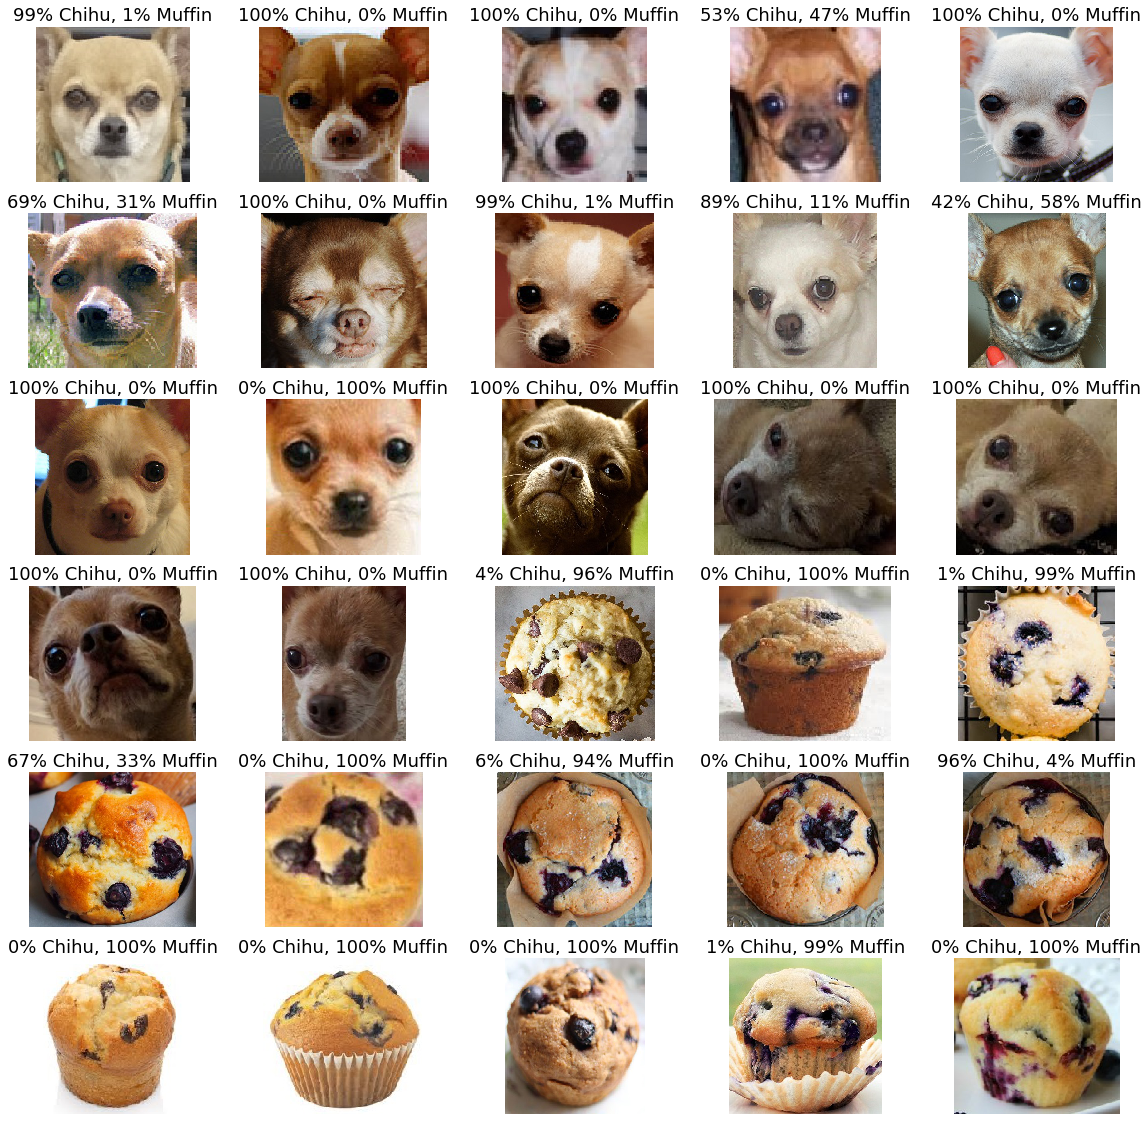

In [23]:
validation(model2)